# Prior Inspection

This notebook inspects fit results for each object and edits the priors for any bad fits.


In [21]:
import sys
from copy import deepcopy

import pandas as pd
import sncosmo
from astropy.table import Table, unique
from SNData.csp import dr3
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline import get_priors_paths, get_fit_results, split_data, fit_lc
from analysis_pipeline._lc_fitting._fit_funcs import get_priors_table


In [17]:
dr3.download_module_data()
dr3.register_filters(force=True)
salt2_4 = sncosmo.Model('salt2')


In [18]:
def get_priors(module, model):
    """Get priors for a given survey and model
    
    Args:
        survey_name (str): The abbreviation of the survey (e.g. 'csp')
        model     (Model): The model of the priors
        
    Returns:
        A pandas data frame indexed on object ID
    """

    model = deepcopy(model)
    auto_priors_path, _ = get_priors_paths(module.survey_abbrev.lower(), model)
    return get_priors_table(model, auto_priors_path).to_pandas().set_index('obj_id')

def save_priors(module, model, priors_dict):
    """Save priors to the analysis pipeline's internal file structure
    
    Args:
        survey_name  (str): The abbreviation of the survey (e.g. 'csp')
        model      (Model): The model of the priors
        priors_dict (dict): Dictionary of prior values
    """

    _, manual_priors_path = get_priors_paths(module.survey_abbrev.lower(), model)
    existing_data = Table.read(manual_priors_path)
    existing_data.add_row(priors_dict)
    new_data = unique(existing_data, keep='last')
    new_data.write(manual_priors_path, overwrite=True)


def plot_lightcurves(obj_id, module, model, fit_results):
    """Plot a light curve
    
    Args:
        data           (Table): The light curve data to plot
        model          (Model): The model to plot
        results_df (DataFrame): Pipeline fit results
    """

    data = [module.get_sncosmo_input(obj_id)]
    data += split_data(data[0], module.band_names, module.lambda_effective)
    for data_table, df in zip(data, fit_results):
        fit_results = df.loc[obj_id]

        model = deepcopy(model)
        params = {p: fit_results[p] for p in model.param_names}
        model.update(params)

        sncosmo.plot_lc(data_table, model)
        plt.show()


## Inspecting fit results

Start by building an iterator

In [19]:
# Specify values in this code block
module_to_inspect = dr3
start_at_id = None
model_to_inspect = salt2_4
params_to_inspect = 4

# Read in data and build iterator of object ids
priors = get_priors(module_to_inspect, model_to_inspect)
fits = get_fit_results(module_to_inspect, model_to_inspect, params_to_inspect)
ids = sorted(dr3.get_available_ids())
if start_at_id:
    ids = ids[ids.index(start_at_id):]

ids = iter(ids)


In [20]:
priors.loc['SN2008J']

z            0.015900
z_min        0.003500
z_max        0.084000
t0        1469.897037
t0_min    1469.540000
t0_max    1516.520000
x0           0.008402
x0_min       0.000000
x0_max       0.050000
x1           0.629270
x1_min      -5.000000
x1_max       5.000000
c            0.998378
c_min       -1.000000
c_max        1.000000
Name: SN2008J, dtype: float64

Inspect the current fit results

Inspecting SN2004dt


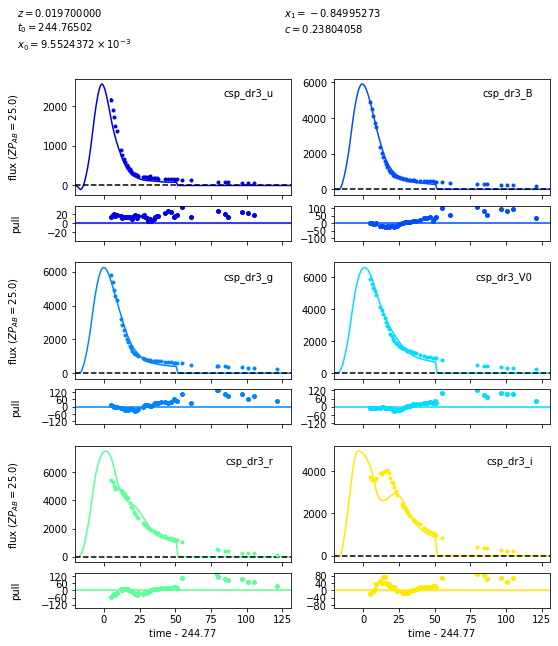

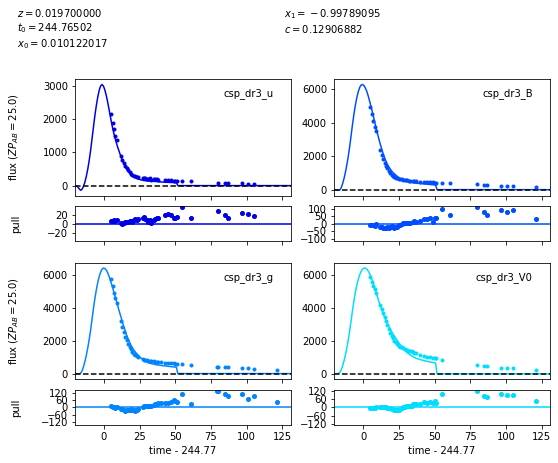

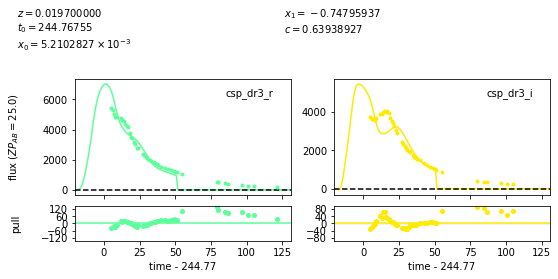

In [5]:
current_id = next(ids)
print(f'Inspecting {current_id}')
plot_lightcurves(current_id, module_to_inspect, model_to_inspect, fits)


Take note of the current priors

In [6]:
priors_this = priors.loc[current_id]
print(priors_this)
priors_dict = {p: (priors_this[f'{p}_min'], priors_this[f'{p}_max']) for p in model_to_inspect.param_names}

z           0.019700
z_min       0.003500
z_max       0.084000
t0        244.765844
t0_min    234.790000
t0_max    365.620000
x0          0.009557
x0_min      0.000000
x0_max      0.050000
x1         -0.846776
x1_min     -5.000000
x1_max      5.000000
c           0.237979
c_min      -1.000000
c_max       1.000000
Name: SN2004dt, dtype: float64


Pick the data to fit and update the priors as necessary

In [7]:
data_to_fit = 'red'  # 'all', 'blue', or 'red'
# priors_dict['z'] = (0, 1)

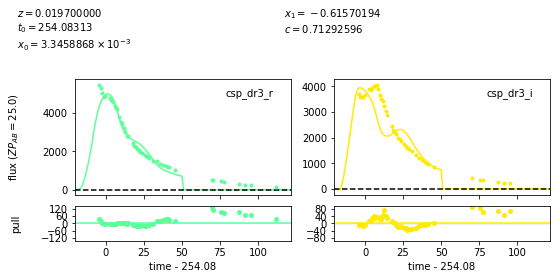

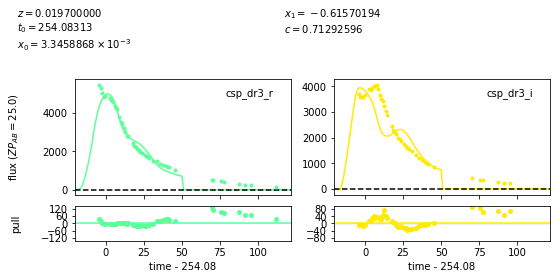

In [8]:
data = module_to_inspect.get_sncosmo_input(current_id)
blue, red = split_data(
    data,
    module_to_inspect.band_names, 
    module_to_inspect.lambda_effective)

data = {'all': data, 'blue': blue, 'red': red}[data_to_fit]

model_this = deepcopy(model_to_inspect)
vparams = model_to_inspect.param_names[5 - params_to_inspect:]
if 'z' not in vparams:
    model_this.set(z=data.meta['redshift'])

fit_results = fit_lc(data, model_this, vparams)

z =  fit_results[2]
t0 = fit_results[3]
x0 = fit_results[4]
x1 = fit_results[5]
c = fit_results[6]
model_this.set(z=z, t0=t0, x0=x0, x1=x1, c=c)

sncosmo.plot_lc(data, model_this)


Save the priors to file

In [ ]:
save_priors(module, model, priors_dict)